# Deprecated - use pipeline-holo.ipynb instead
# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob

import pyopia.classify
import pyopia.process
import pyopia.statistics
import pyopia.io
from pyopia.holo import statextract_holo

import skimage.io as skio

ModuleNotFoundError: No module named 'pyopia.holo'

# List raw data files

In [3]:
# put some example images in a folder defined by raw_data
# you can find examples here: https://pysilcam.blob.core.windows.net/test-data/example_silc_data.zip
#raw_data = "raw_data"
#raw_files = glob(os.path.join(raw_data, '*.silc'))
#raw_files

# Define non-defult settings for anlayis, or custom functions

In [4]:
def statextract_holo(data, Classification, extractparticles_function=None, max_particles=np.inf):

    timestamp = data[1]
    im_flat = data[2]

    imbw = data[3]
    imbw = np.max(imbw, axis=2)  # quick conversion from montage to binary image

    # a work-around to make image dimensions fit - we should look into making an option for working on grayscale images
    # for now, we can just copy the grayscale into three 'RGB' channels
    r, c = np.shape(im_flat)
    img = np.zeros((r, c, 3), dtype=np.uint8)
    img[:, :, 0] = im_flat
    img[:, :, 1] = im_flat
    img[:, :, 2] = im_flat

    region_properties = pyopia.process.measure_particles(imbw, max_particles=max_particles)

    # build the stats and export to HDF5
    stats = extractparticles_function(img, timestamp, Classification, region_properties)

    saturation = None

    return stats, imbw, saturation

In [5]:
from functools import partial
# The inbuilt partial function allows redefining of optional input arguments.
# This means that lower-level functions in pyopia.process that contain several optional settings
# can be changed using partial without having to pass these optional inputs through all levels in the code.

# define a modified export_particles function, that states an output directory (test_export)
# for saving exported ROIs
extractparticles_function = partial(pyopia.process.extract_particles,
                                    export_outputpath='export_holo')

# give this extractparticles_function function to statextract
# and if you want to, edit settings in statextract
# when we call pyopia.process_image later, we will give it statextract_function to apply these options 
statextract_function = partial(statextract_holo, extractparticles_function=extractparticles_function)

# Initialise the CNN

In [6]:
# initialise the Classify class
cl = pyopia.classify.Classify()

# at this point you could overwrite custom classification functions,
# like cl.proc_predict() to work with a different classification network

# load the model (this example can be found here:
#    https://github.com/SINTEF/PySilCam/wiki/ml_models/keras_model.zip)
cl.load_model(model_path="C:\model\keras_model.h5")

# Calculate particle statistics for each image

In [7]:
# define a place for storing the summary statistics using pyopia.io.write_stats
# prefix filename and path. 
datafile_hdf = 'proc/test' # The actual filename will be 'proc/test-STATS.h5' in this case

# for mulytiple images, loop through a raw_files list, and do the below for every image
# e.g. : 'for filename in raw_files:'
imbw_filename = 'data/D20220609T211859-dep.tiff'
img_filename = 'data/D20220609T211859-mon.tiff'

im_flat = skio.imread(img_filename) # this is the flattened 'real' images from the holo

imbw = skio.imread(imbw_filename) # this is the montage from the holo

# get the timestamp of the image (in this case from the filename)
timestamp = pd.to_datetime(os.path.splitext(os.path.basename(img_filename))[0].strip('-mon')[1:])
print(timestamp)

# setup the 'data' tuple with an image number, timestamp, flattened graysacale image, binary image
data = (1, timestamp, im_flat, imbw)

# call process_image
stats = pyopia.process.process_image(cl, data, statextract_function=statextract_function)

# setup the 'data' tuple with an image number, timestamp, flattened graysacale image, binary image
data = (2, timestamp, im_flat, imbw)

# call process_image
stats = pyopia.process.process_image(cl, data, statextract_function=statextract_function)

# rather than appending an ever-growing stats daraframe on each image, it is best to just append these data to
# the *-STATS.h5 file, which will grow on each iamge loop
pyopia.io.write_stats(datafile_hdf, stats)
stats

2022-06-09 21:18:59
Processing time stamp 2022-06-09 21:18:59
  4 particles found
EXTRACTING 4 IMAGES from 4
  Image 1 processed in 0.20 sec (4.9 Hz). 
Processing time stamp 2022-06-09 21:18:59
  4 particles found
EXTRACTING 4 IMAGES from 4
  Image 2 processed in 0.17 sec (5.9 Hz). 


,major_axis_length,minor_axis_length,equivalent_diameter,solidity,minr,minc,maxr,maxc,probability_oil,probability_other,probability_bubble,probability_faecal_pellets,probability_copepod,probability_diatom_chain,probability_oily_gas,export name,timestamp,saturation
0,103.083596,18.141181,36.737364,0.597183,455.0,1207.0,499.0,1305.0,2.593902e-06,0.999829,1.836331e-07,1.854228e-05,1.497655e-04,8.640367e-11,6.101168e-10,D20220609T211859.000000-PN0,2022-06-09 21:18:59,None
1,6.978627,6.738353,6.863663,0.948718,847.0,535.0,854.0,542.0,3.608036e-04,0.832963,1.663784e-01,2.230411e-07,6.681279e-06,1.188448e-05,2.792467e-04,D20220609T211859.000000-PN1,2022-06-09 21:18:59,None
2,5.752502,4.833450,5.170883,0.913043,855.0,1892.0,861.0,1898.0,2.195622e-06,0.892875,1.071115e-01,2.565938e-08,1.161665e-05,6.780100e-09,6.409046e-08,D20220609T211859.000000-PN2,2022-06-09 21:18:59,None
3,17.009108,11.379699,13.303394,0.817647,1091.0,2218.0,1109.0,2230.0,1.312514e-08,0.999999,1.283487e-06,2.529618e-08,6.778289e-09,8.733822e-14,3.500429e-09,D20220609T211859.000000-PN3,2022-06-09 21:18:59,None


## The STATS.h5 data

In [8]:
# display metadata in the h5
pyopia.io.show_h5_meta(datafile_hdf + '-STATS.h5')

Modified:
    2022-06-28 13:29:13.529190
PyOpia version:
    0.0.8


In [9]:
# load the stats DataFrame from the h5 file
stats = pd.read_hdf(datafile_hdf + '-STATS.h5', 'ParticleStats/stats')
stats

,major_axis_length,minor_axis_length,equivalent_diameter,solidity,minr,minc,maxr,maxc,probability_oil,probability_other,probability_bubble,probability_faecal_pellets,probability_copepod,probability_diatom_chain,probability_oily_gas,export name,timestamp,saturation
0,103.083596,18.141181,36.737364,0.597183,455.0,1207.0,499.0,1305.0,2.593902e-06,0.999829,1.836331e-07,1.854228e-05,1.497655e-04,8.640367e-11,6.101168e-10,D20220609T211859.000000-PN0,2022-06-09 21:18:59,NaN
1,6.978627,6.738353,6.863663,0.948718,847.0,535.0,854.0,542.0,3.608036e-04,0.832963,1.663784e-01,2.230411e-07,6.681279e-06,1.188448e-05,2.792467e-04,D20220609T211859.000000-PN1,2022-06-09 21:18:59,NaN
2,5.752502,4.833450,5.170883,0.913043,855.0,1892.0,861.0,1898.0,2.195622e-06,0.892875,1.071115e-01,2.565938e-08,1.161665e-05,6.780100e-09,6.409046e-08,D20220609T211859.000000-PN2,2022-06-09 21:18:59,NaN
3,17.009108,11.379699,13.303394,0.817647,1091.0,2218.0,1109.0,2230.0,1.312514e-08,0.999999,1.283487e-06,2.529618e-08,6.778289e-09,8.733822e-14,3.500429e-09,D20220609T211859.000000-PN3,2022-06-09 21:18:59,NaN
0,103.083596,18.141181,36.737364,0.597183,455.0,1207.0,499.0,1305.0,2.593902e-06,0.999829,1.836331e-07,1.854228e-05,1.497655e-04,8.640367e-11,6.101168e-10,D20220609T211859.000000-PN0,2022-06-09 21:18:59,NaN
1,6.978627,6.738353,6.863663,0.948718,847.0,535.0,854.0,542.0,3.608036e-04,0.832963,1.663784e-01,2.230411e-07,6.681279e-06,1.188448e-05,2.792467e-04,D20220609T211859.000000-PN1,2022-06-09 21:18:59,NaN
2,5.752502,4.833450,5.170883,0.913043,855.0,1892.0,861.0,1898.0,2.195622e-06,0.892875,1.071115e-01,2.565938e-08,1.161665e-05,6.780100e-09,6.409046e-08,D20220609T211859.000000-PN2,2022-06-09 21:18:59,NaN
3,17.009108,11.379699,13.303394,0.817647,1091.0,2218.0,1109.0,2230.0,1.312514e-08,0.999999,1.283487e-06,2.529618e-08,6.778289e-09,8.733822e-14,3.500429e-09,D20220609T211859.000000-PN3,2022-06-09 21:18:59,NaN
0,103.083596,18.141181,36.737364,0.597183,455.0,1207.0,499.0,1305.0,2.593902e-06,0.999829,1.836331e-07,1.854228e-05,1.497655e-04,8.640367e-11,6.101168e-10,D20220609T211859.000000-PN0,2022-06-09 21:18:59,NaN
1,6.978627,6.738353,6.863663,0.948718,847.0,535.0,854.0,542.0,3.608036e-04,0.832963,1.663784e-01,2.230411e-07,6.681279e-06,1.188448e-05,2.792467e-04,D20220609T211859.000000-PN1,2022-06-09 21:18:59,NaN


# Analysis, statistics and plotting

Text(0, 0.5, 'Volume Distribution [uL/sample vol.]')

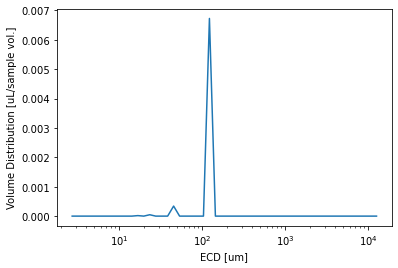

In [10]:
# there are lots of functions in pyopia.statistics. Here is just an example.

# Calculate the volume distribution from the stats DataFrame.
dias, vd = pyopia.statistics.vd_from_stats(stats, 3.45)

# plot the volume distribution
plt.plot(dias, vd)
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')